# Transmission and Resonant Modes of a Waveguide Cavity

## Transmission Spectrum

To calculate the transmission spectrum, much as in the bend example in Tutorial/Basics, we'll measure the flux spectrum at one end of the waveguide from a source at the other end, normalized by the flux from a case with no holes in the waveguide. First, we'll load the necessary modules.

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Video

%matplotlib notebook

Using MPI version 3.1, 1 processes


Next, we'll define some parameters of our structure. All lengths are in units of microns ($\mu$m). The periodicity of the photonic crystal is 1 $\mu$m.

In [2]:
resolution = 20  # pixels/um

eps = 13  # dielectric constant of waveguide
w = 1.2  # width of waveguide
r = 0.36  # radius of holes
d = 1.4  # defect spacing (ordinary spacing = 1)
N = 3  # number of holes on either side of defect

sy = 6  # size of cell in y direction (perpendicular to wvg.)
pad = 2  # padding between last hole and PML edge
dpml = 1  # PML thickness

Given these parameters, the size of the cell in the X direction, which we'll denote `sx`, is given by:

In [3]:
sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction

Now, the computational cell is:

In [4]:
cell = mp.Vector3(sx, sy, 0)

The `geometry` will consist of a single `Block` for the waveguide, and `2N` cylindrical holes:

In [5]:
blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
geometry = [blk]

for i in range(N):
    geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
    geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

To create the holes, we have used a `for` loop. Note that the `geometry` objects are combined using the `append` function. As usual, later objects in `geometry` take precedence over earlier objects, so the  `Cylinder` objects will punch holes through the `Block`.

The absorbing boundaries surrounding the computational cell are:

In [6]:
pml_layers = [mp.PML(1.0)]

Now, we'll define a couple of parameters to determine the frequency range to investigate. We already know from our previous calculations that this structure has a $H_z$-polarized band gap for frequencies in the range 0.2 to 0.3, so we'll want to cover this interval.

In [7]:
fcen = 0.25  # pulse center frequency
df = 0.2  # pulse frequency width

The source will now be the usual Gaussian pulse centered at `fcen`, located at one edge of the cell just outside the PML, at `x = - 0.5 * sx + dpml`. Ideally, we would excite exactly the fundamental mode of the waveguide, but it is good enough to just excite it with a line source. Moreover, since we are interested in the $P$ polarization (electric field in the plane), we will excite it with a $J_y$ current source (transverse to the propagation direction), which is specified as $E_y$:

In [8]:
src = [
    mp.Source(
        mp.GaussianSource(fcen, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(-0.5 * sx + dpml),
        size=mp.Vector3(0, w),
    )
]

The structure has mirror symmetry planes through the $X$ and $Y$ axes. The source breaks the mirror symmetry through the $Y$ axis, but we still have odd mirror symmetry through the $Z$ axis:

In [9]:
sym = [mp.Mirror(mp.Y, phase=-1)]

Note that we specify the plane by its normal, the $Y$ direction. See also Exploiting Symmetry. Putting all these objects together via the `Simulation` object:

In [10]:
sim = mp.Simulation(
    cell_size=cell,
    geometry=geometry,
    boundary_layers=pml_layers,
    sources=src,
    symmetries=sym,
    resolution=resolution,
)

We need to compute the flux spectrum at the other end of the computational cell, after the holes but before the PML:

In [11]:
freg = mp.FluxRegion(
    center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
)

nfreq = 500  # number of frequencies at which to compute flux

# transmitted flux
trans = sim.add_flux(fcen, df, nfreq, freg)

Finally, we can visualize the simulation domain to ensure that everything was coded correctly.

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)


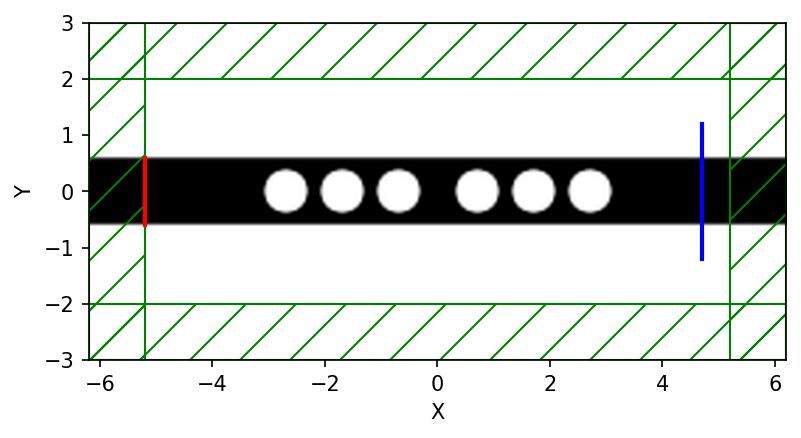

In [12]:
f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca())
plt.show()

Now, we can run the simulation until the sources have finished plus some additional time to allow the fields to propagate through the structure. As in Tutorial/Basics, we'll use `stop_when_fields_decayed` to increment the time in steps of 50 time units (about 13 periods) until $|E_y|^2$ has decayed by at least 1/1000 at the transmission-flux plane.

We'll also animate the fields and generate a video.

In [13]:
f = plt.figure(dpi=150)
animate = mp.Animate2D(f=f, fields=mp.Hz, realtime=False, normalize=True)

sim.run(
    mp.during_sources(mp.at_every(0.4, animate)),
    until_after_sources=mp.stop_when_fields_decayed(
        50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
    ),
)
plt.close()

Normalizing field data...
field decay(t = 50.025000000000006): 3.95790820471984e-05 / 3.95790820471984e-05 = 1.0
field decay(t = 100.05000000000001): 6.062401894821014e-05 / 6.062401894821014e-05 = 1.0
field decay(t = 150.07500000000002): 1.7734570553698603e-05 / 6.062401894821014e-05 = 0.2925337326918046
field decay(t = 200.10000000000002): 7.468025297259177e-06 / 6.062401894821014e-05 = 0.12318591586016357
field decay(t = 250.125): 5.439633091350728e-06 / 6.062401894821014e-05 = 0.08972735865627277
field decay(t = 300.15000000000003): 4.23291165174129e-06 / 6.062401894821014e-05 = 0.06982235300759884
field decay(t = 350.175): 3.476628845824414e-06 / 6.062401894821014e-05 = 0.05734738320127583
field decay(t = 400.20000000000005): 2.847134687922034e-06 / 6.062401894821014e-05 = 0.04696380638100359
field decay(t = 450.225): 2.3289750979705154e-06 / 6.062401894821014e-05 = 0.03841670576079938
field decay(t = 500.25): 1.9177580551625897e-06 / 6.062401894821014e-05 = 0.031633634464268874
f

In [14]:
filename = "media/hole-wvg-cavity.mp4"
animate.to_mp4(10, filename)
Video(filename)

Generating MP4...


We can see the pulse propagating to the right, bouncing off of the holes, and also exciting a resonant mode in the cavity that sits in the center for a long time as it starts slowly leaking to the right.

Of course, the main point of this section is to get the quantitative transmission spectrum. To do this, we need to normalize our flux by running the simulation with no holes. We'll first wrap the above code in a function so that we can parameterize the simulation domain.

In [15]:
def sim_cavity(N=3, sy=6):
    sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    for i in range(N):
        geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

    src = [
        mp.Source(
            mp.GaussianSource(fcen, fwidth=df),
            component=mp.Ey,
            center=mp.Vector3(-0.5 * sx + dpml),
            size=mp.Vector3(0, w),
        )
    ]

    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        symmetries=sym,
        resolution=resolution,
    )

    freg = mp.FluxRegion(
        center=mp.Vector3(0.5 * sx - dpml - 0.5), size=mp.Vector3(0, 2 * w)
    )
    nfreq = 500
    trans = sim.add_flux(fcen, df, nfreq, freg)

    sim.run(
        until_after_sources=mp.stop_when_fields_decayed(
            50, mp.Ey, mp.Vector3(0.5 * sx - dpml - 0.5), 1e-3
        )
    )

    freqs = mp.get_flux_freqs(trans)
    psd = mp.get_fluxes(trans)

    return freqs, psd

Now we can compute the fluxes for both the simple waveguide and the cavity:

In [16]:
freqs_wg, psd_wg = sim_cavity(N=0)  # simple waveguide
freqs_cav, psd_cav = sim_cavity()  # cavity

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
field decay(t = 50.025000000000006): 0.024304124551377593 / 0.024304124551377593 = 1.0
field decay(t = 100.05000000000001): 0.00029478773644369007 / 0.024304124551377593 = 0.012129123837418002
field decay(t = 150.07500000000002): 8.914669657976724e-14 / 0.024304124551377593 = 3.667965755825354e-12
run 0 finished at t = 150.07500000000002 (6003 timesteps)
-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, 

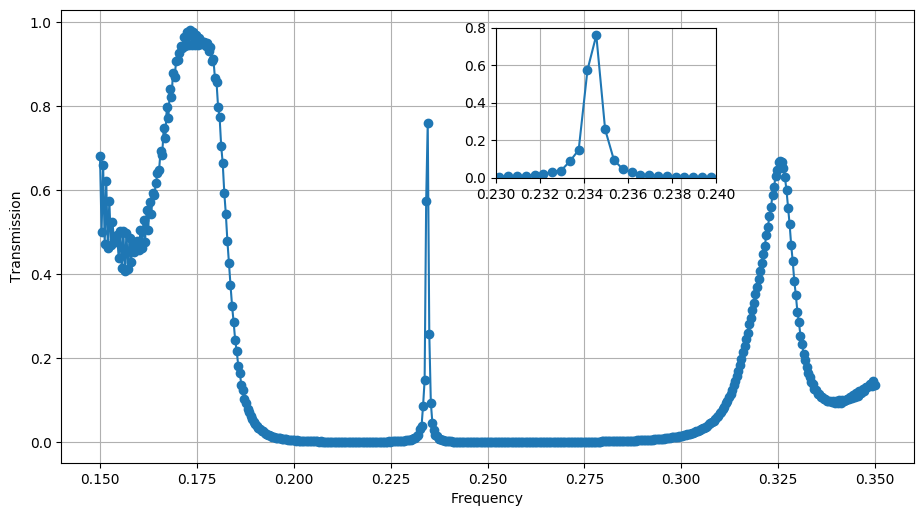

In [17]:
fig = plt.figure(figsize=(11, 6), dpi=100)
ax = fig.add_subplot(111)
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.grid(True)
plt.xlabel("Frequency")
plt.ylabel("Transmission")

ax2 = fig.add_axes([0.52, 0.6, 0.2, 0.25])
plt.plot(freqs_cav, np.array(psd_cav) / np.array(psd_wg), "o-")
plt.xlim(0.23, 0.24)
plt.ylim(0, 0.8)
plt.grid(True)

The band gap is clearly visible as the range of very low transmission, and in the middle of the band gap is a sharp peak corresponding to the resonant mode trapped in the defect. The inset enlarges this peak, and shows that we didn't use quite enough frequency points to capture the whole shape although we could fit to a Lorentzian if we wanted. At the edges of the band gaps, the transmission goes up in broad Fabry-Perot resonance peaks which we will examine in more detail below. There is also some high-frequency oscillation visible at the left of the plot, which is a numerical artifact due to our pulse not having enough amplitude in that range.

The narrower the resonance peak (higher Q), the harder this sort of direct transmission simulation is to perform — because of the Fourier uncertainty principle, we need to run for a time inversely related to the frequency resolution we would like to obtain. Fortunately, there is a much better way to study high-Q resonances, as described in the next section. See also Tutorial/Basics/Modes of a Ring Resonator.

## Resonant Modes

To study high-Q (long lifetime) resonant modes, it is much more efficient to excite them directly, placing a source inside the cavity, and analyze the resulting fields to obtain the frequencies and lifetimes of the modes. Here, we do precisely that for the above structure. See also Tutorial/Basics/Modes of a Ring Resonator and the Introduction.

The structure is exactly the same as above, and only the sources and analysis are different. We'll create another function that parameterizes the simulation and returns the corresponding simulation object.

This time, the new source is still a Gaussian, but is now a point source at the origin. Moreover, we are now using a magnetic current oriented in the z direction ($H_z$). This source matches the symmetry of the $H_z$-polarized resonant mode that we are looking for. If we didn't know in advance what symmetry we were looking for, we would put the source off-center in a non-symmetric location, which would excite all modes regardless of symmetry. However, in many cases the symmetry is known, and placing a symmetric source allows us to limit the number of modes we excite and also to exploit the fact that we now have two mirror symmetry planes in this problem, saving us a factor of four in computation

In [18]:
def sim_cavity(N=3, sy=6, fcen=0.25, df=0.2):
    sx = 2 * (pad + dpml + N) + d - 1  # size of cell in x direction
    cell = mp.Vector3(sx, sy, 0)
    blk = mp.Block(size=mp.Vector3(mp.inf, w, mp.inf), material=mp.Medium(epsilon=eps))
    geometry = [blk]

    for i in range(N):
        geometry.append(mp.Cylinder(r, center=mp.Vector3(d / 2 + i)))
        geometry.append(mp.Cylinder(r, center=mp.Vector3(-(d / 2 + i))))

    src = [mp.Source(mp.GaussianSource(fcen, fwidth=df), mp.Hz, mp.Vector3(0))]

    sym = [mp.Mirror(mp.Y, phase=-1), mp.Mirror(mp.X, phase=-1)]

    sim = mp.Simulation(
        cell_size=cell,
        geometry=geometry,
        boundary_layers=pml_layers,
        sources=src,
        symmetries=sym,
        resolution=resolution,
    )

    return sim

Here, you may notice a strange thing: we have specified `phase=-1` for both mirror planes corresponding to odd symmetry. However, it may seem at first glance that an $H_z$ dipole at the origin has even symmetry! The subtlety here is that the magnetic field is a pseudovector, and is multiplied by −1 under mirror flips, so it is odd when it looks even and vice versa. We aren't just being pedantic here — if you don't realize the difference between vectors, such as electric fields and currents, and pseudovectors, such as magnetic fields and currents, then you will have endless confusion because the electric and magnetic fields will seem to have different symmetry. See also Exploiting Symmetry.

We'll next visualize our domain to make sure everything looks correct:

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)


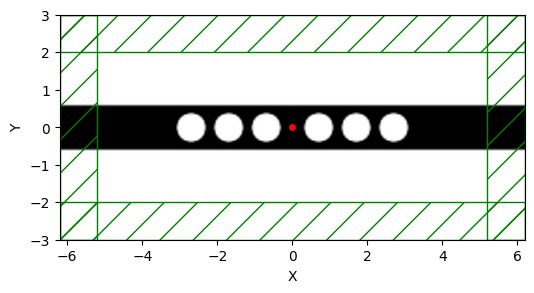

In [19]:
sim = sim_cavity()
f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Finally, we can begin the time stepping and animate the fields. 

Just as in Tutorial/Basics/Modes of a Ring Resonator, we use the `harminv` command (which calls Harminv) to analyze the response at a point (here the $H_z$ field at the origin) for some time after the source has turned off.

In [20]:
h = mp.Harminv(mp.Hz, mp.Vector3(), fcen, df)
sim.run(mp.after_sources(h), until_after_sources=400)

f = plt.figure(dpi=150)
animate = mp.Animate2D(f=f, fields=mp.Hz, realtime=False, normalize=True)

sim.run(mp.at_every(1 / fcen / 20, animate), until=1 / fcen)
plt.close()

harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.23445415345698725, -0.0003147812363599428, 372.4080827818086, 5.812143030902256, -3.763107501450195-4.429450140163555i, 4.306293489743804e-09+0.0i
run 0 finished at t = 450.0 (18000 timesteps)
Normalizing field data...
run 1 finished at t = 454.0 (18160 timesteps)


In [21]:
filename = "media/hole-wvg-cavity-res.mp4"
animate.to_mp4(10, filename)
Video(filename)

Generating MP4...


Inspecting the animation, we see a single resonant mode in the gap. We can verify this by pulling Harminv's results:

In [22]:
f = [m.freq for m in h.modes]
Q = [m.Q for m in h.modes]

for fiter, qiter in zip(f, Q):
    print(f"Resonant frequency: {fiter}, Q: {qiter}")

Resonant frequency: 0.23445415345698725, Q: 372.4080827818086


The mode has a frequency of 0.235, just as we saw in the transmission spectrum, and a $Q$ of 373 which we could have also found by fitting the transmission spectrum. This lifetime $Q$ includes two independent decay channels: light can decay from the cavity into the waveguide with lifetime $Q_w$, or it can radiate from the cavity into the surrounding air with lifetime $Q_r$, where

$$\frac{1}{Q} = \frac{1}{Q_w} + \frac{1}{Q_r}

See Chapter 10 of Photonic Crystals: Molding the Flow of Light (second edition) for more details. There are a variety of ways to separate out the two decay channels. For example, we can look at the power radiated in different directions. Here, we'll just increase the number `N` of holes and see what happens — as we increase `N`, $Q_w$ should increase exponentially while $Q_r$ remains roughly fixed, so that $Q$ eventually saturates at $Q_r$.

In [23]:
N_vec = np.arange(2, 16, 2)
f = []
Q = []
for N in N_vec:
    sim = sim_cavity(N=N)
    h = mp.Harminv(mp.Hz, mp.Vector3(), fcen, df)
    sim.run(mp.after_sources(h), until_after_sources=400)
    f.append([m.freq for m in h.modes])
    Q.append([m.Q for m in h.modes])

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.2340278559161547, -0.0018734141261924503, 62.4602570900316, 4.626071402369734, -2.8205983802960652-3.6667098872005526i, 4.878861173642782e-09+0.0i
run 0 finished at t = 450.0 (18000 timesteps)
-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, cen

     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (3.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-3.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (4.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-4.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (5.7,0,0

In [24]:
for fiter, qiter in zip(f, Q):
    print(f"Resonant frequency: {fiter}, Q: {qiter}")

Resonant frequency: [0.2340278559161547], Q: [62.4602570900316]
Resonant frequency: [0.23453222952425626, 0.3203380792800332], Q: [1604.356419256047, 56.98395142519764]
Resonant frequency: [0.23454147739266504, 0.32588515566889864], Q: [5748.049556662018, 87.97763628993552]
Resonant frequency: [0.19490287264916165, 0.23454251746066898, 0.325392318417585], Q: [137.27823190347084, 6015.071672339521, 56.57766432120712]
Resonant frequency: [0.19654202912381852, 0.23454237393497965, 0.32477010784223226], Q: [744.6401123571296, 6081.619522749968, 171.65851844557693]
Resonant frequency: [0.1689088120846072, 0.2345423978640612, 0.3112255725190105, 0.3253120677284504], Q: [99.9969165790139, 6078.897969217604, 301.5900376672834, 217.7087420565448]
Resonant frequency: [0.18634339022479032, 0.23454234757429138, 0.3251536244537306], Q: [159.31934325638528, 6073.9587792330785, 212.06285797404294]


When we look at the Harminv output for larger N, something strange happens — it starts to find _more_ modes! We'll examine why later. First, let's visualize the Q around the fundamental mode we initially detected ($\omega=0.234$).

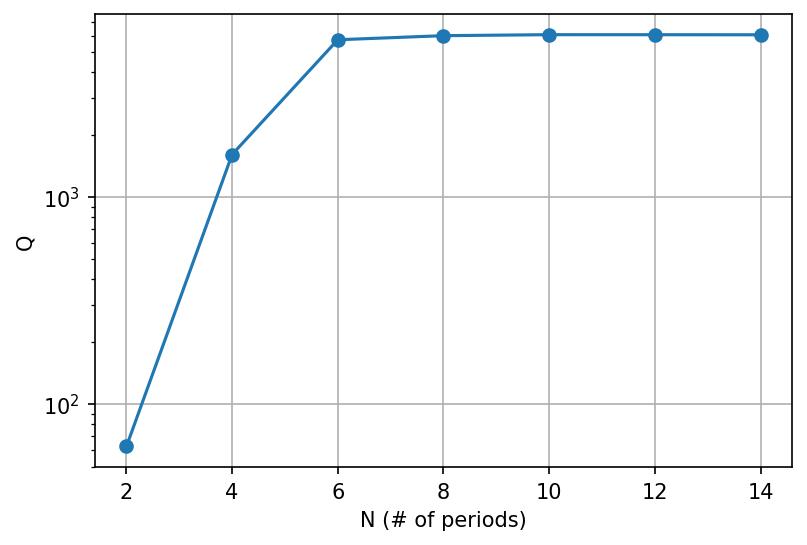

In [25]:
idx = np.zeros(N_vec.shape)
Q_fund = np.zeros(N_vec.shape)
for i in range(N_vec.size):
    idx[i] = np.abs(np.array(f[i]) - 0.234).argmin()
    Q_fund[i] = Q[i][int(idx[i])]

plt.figure(dpi=150)
plt.semilogy(N_vec, Q_fund, "o-")
plt.grid(True)
plt.xlabel("N (# of periods)")
plt.ylabel("Q")
plt.show()

The results, shown above, are exactly what we expected: at first, an exponential increase of $Q$ with `N`, and then a saturation at $Q_r≈8750$.

Now, what is this extra mode at $\omega$=0.32823? This is right around the edge of the band gap (actually, just above the edge). There are two possibilities. First, it could be a band edge state: the propagating states in the periodic waveguide go to zero group velocity as they approach the edge of the gap, corresponding to long-lived resonances in a long but finite crystal. Second, it could be a higher-order resonant mode that for a slightly larger defect will be pulled further into the gap, but is currently very delocalized. In this case, it turns out to be the latter. 

To see the mode, we will simply run the simulation again with a narrow-band source, and we will also increase the y cell size `sy` because it turns out that the mode is fairly spread out in that direction:

In [26]:
sim = sim_cavity(N=16, sy=12, fcen=0.328227374843021, df=0.1)
sim.run(until_after_sources=600)

-----------
Initializing structure...
     block, center = (0,0,0)
          size (1e+20,1.2,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
     cylinder, center = (0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-0.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-1.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-2.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (3.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-3.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (4.7,0,0)
          radius 0.36, height 1e+20, axis (0, 0, 1)
     cylinder, center = (-4.7,0,0)
          radius 0.36, height 1e+20, axis (0, 

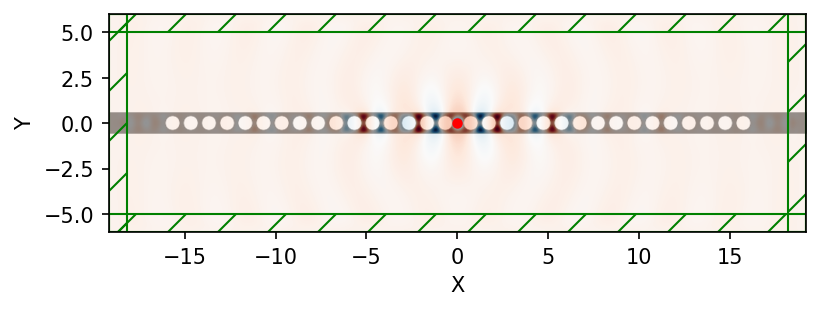

In [27]:
f = plt.figure(dpi=150)
sim.plot2D(ax=f.gca(), fields=mp.Hz)
plt.show()

From the image, the field is clearly localized around the defect in the center as opposed to being spread out evenly in the crystal like a band-edge state would be. In the defect, the pattern is higher order than the previous mode. It has an extra pair of nodes in the y direction.